Universidade Federal do Rio Grande do Sul (UFRGS)   
Programa de Pós-Graduação em Engenharia Civil (PPGEC)   

# Load/Unload – Displacement Response of Reinforced-Concrete Flexible Laterally Loaded Piles in Residual Soil Site

---
_Nilo Cesar Consoli, Naiara Costa Reginato, Luizmar da Silva lopes Júnior,  
Vítor Pereira Faro, Ricardo Bergan Born, and Yohan Casiraghi_

(Data post-processing by _Marcelo Maia Rocha_)

_Porto Alegre, RS, Brazil_ 

___

[1.   Piles P1 and P2 properties](#section_1)   
[2.   Slope data input and visualization](#section_2)  
[3.   Pile moment-curvature relations](#section_3)  
[3.1. In elastic domain](#section_31)  
[3.2. After plastic hinge formation](#section_32)  
[4.   Data analysis through finite differences derivation](#section_4)   
[5.   Estimation of bending moments](#section_5)   
[5.1  Through a linear moment-curvature relation](#section_51)   
[5.2  With a non-linear moment-curvature relation](#section_52)   
[6.   Theoretical soil reaction function](#section_6)   
[7.   Estimation of resultant lateral soil reactions](#section_7)   

---


In [3]:
# Módulos Python necessários neste notebook:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
        
fP1 = 'ProcessingData_P1.xlsx'
fP2 = 'ProcessingData_P2.xlsx'

excelP1 = pd.ExcelWriter(fP1)
excelP2 = pd.ExcelWriter(fP2)


## 1. Piles P1 and P2 properties  <a name="section_1"></a>

Piles P1 and P2 properties are as follows:

1. Transversal sections

<img src="pile_sections.png" alt="pile sections" width="640px"/>

2. Concrete section properties

<img src="pile_concrete.png" alt="pile concrete" width="600px"/>

3. Stell reinforcement properties

<img src="pile_steel.png" alt="pile steel" width="480px"/>

The most relevant properties for bending moment analysis is the 
total flexural rigidity, $EI$, and the limit resistance moment, $M_{\rm y}$, for each pile:


In [4]:
EI1 = 43986.94 + 4866.74            # Flexural rigidity for pile 1 (kNm2)
My1 = 118.                          # Yielding moment for pile 1 (kNm)

EI2 = 27141.39 +  211.88            # Flexural rigidity for pile 2 (kNm2)
My2 = 27.                           # Yielding moment for pile 2 (kNm)


## 2. Slope data input and visualization  <a name="section_2"></a>

Using ```pandas``` to read all data from data file:

In [5]:
with open('data.xlsx', 'rb') as target:
    
    LP1 =  pd.read_excel(target, sheet_name='loadingP1')
    LP2 =  pd.read_excel(target, sheet_name='loadingP2')
    
    SP1 =  pd.read_excel(target, sheet_name='slopeP1')
    SP2 =  pd.read_excel(target, sheet_name='slopeP2')


Loading/unloading curves for piles P1 and P2:


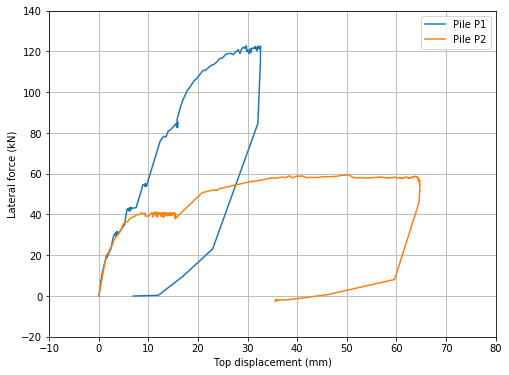

In [6]:
fig1 = plt.figure(1, figsize=(8,6))

plt.plot(LP1.D1, LP1.P1)
plt.plot(LP2.D2, LP2.P2)
plt.axis([-10, 80, -20, 140])
plt.xlabel('Top displacement (mm)')
plt.ylabel('Lateral force (kN)')
plt.legend(('Pile P1', 'Pile P2'))
plt.grid(True)


From these curves, it may be observed that the two piles have a very close behavior up to
a horizontal loading of 36kN. This reference can be interpreted as the upper limit of 
linear behavior assumption for both piles.

The following script gathers the tests within a single matrix, for batch iteration:


In [7]:
# For Pile 1 (test with P = 48kN is a disregarded outlier)

N1  =  np.array([ 0,      2,      4,              8,     10,      12    ], dtype='int')
P1  =  np.array([12,  0, 24,  0, 36,  0, 48,  0, 60,  0, 86,  0, 125,  0])
Z1  =  SP1.values[:,0]
D1  =  SP1.values[:,1:]/1000
L1  =  Z1.max()
Zi1 =  np.linspace(0, L1, 200)
dZ1 =  L1/200

dataP1 = pd.DataFrame(data=D1[:,N1], index=Z1, columns=P1[N1])
dataP1.to_excel(excelP1,'Data')

# For Pile 2

N2  =  np.array([ 0,      2,      4    ], dtype='int')
P2  =  np.array([20,  0, 40,  0, 60,  0])
Z2  =  SP2.values[:,0]
D2  =  SP2.values[:,1:]/1000
L2  =  Z2.max()
Zi2 =  np.linspace(0, L2, 200)
dZ2 =  L2/200

dataP2 = pd.DataFrame(data=D2[:,N2], index=Z2, columns=P2[N2])
dataP2.to_excel(excelP2,'Data')


The following scripts show the deflected pile shapes for preliminary data
inspection. Initially for pile P1:


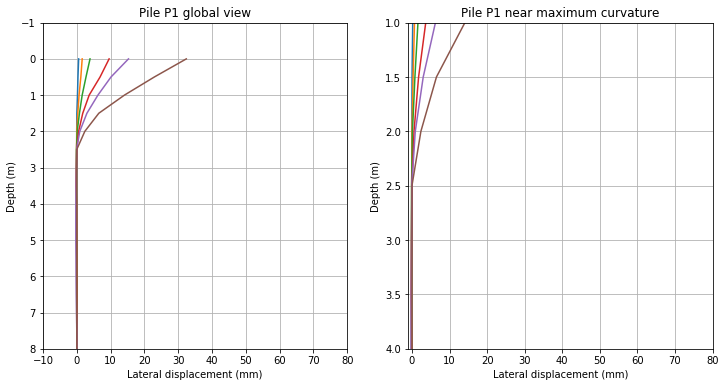

In [8]:
fig2 = plt.figure(2, figsize=(12,6))

plt.subplot(1,2,1)

for k in N1:
    plt.plot(1000*D1[:,k], Z1)

plt.axis([-10, 80, -1, L1])
plt.gca().invert_yaxis()
plt.xlabel('Lateral displacement (mm)')
plt.ylabel('Depth (m)')
plt.title('Pile P1 global view')
plt.grid(True)

plt.subplot(1,2,2)

for k in N1:
    plt.plot(1000*D1[:,k], Z1)

plt.axis([-1, 80, 1, 4])
plt.gca().invert_yaxis()
plt.xlabel('Lateral displacement (mm)')
plt.ylabel('Depth (m)')
plt.title('Pile P1 near maximum curvature')
plt.grid(True)


And then for pile P2:


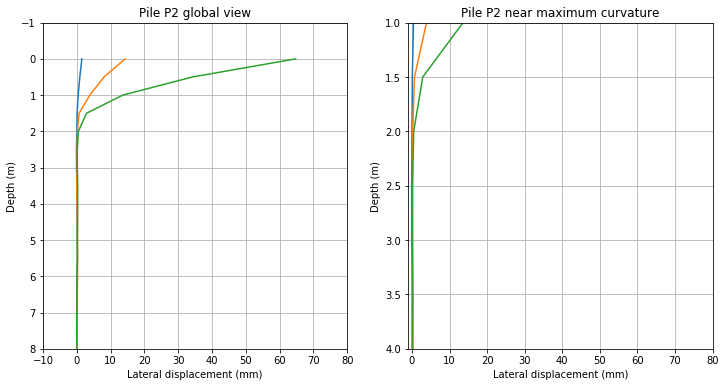

In [9]:
fig3 = plt.figure(3, figsize=(12,6))

plt.subplot(1,2,1)

for k in N2:
    plt.plot(1000*D2[:,k], Z2)

plt.axis([-10, 80, -1, L2])
plt.gca().invert_yaxis()
plt.xlabel('Lateral displacement (mm)')
plt.ylabel('Depth (m)')
plt.title('Pile P2 global view')
plt.grid(True)

plt.subplot(1,2,2)

for k in N2:
    plt.plot(1000*D2[:,k], Z2)

plt.axis([-1, 80, 1, 4])
plt.gca().invert_yaxis()
plt.xlabel('Lateral displacement (mm)')
plt.ylabel('Depth (m)')
plt.title('Pile P2 near maximum curvature')
plt.grid(True)


For some of the tests above it may be assumed that the slope measurements have
been obtained within the linear elastic domain for pile behavior. 
The pile elastic line in these case may be seen as a _probe_ for measuring the
soil reactions. 
For larger loads, both piles have formed a plastic hinge and some assumption
must be made for the non-linear moment-curvature relation.

By inspection of deflected shapes above, one may conclude that beyond the depth of 4m, 
for both piles, lateral displacements are negligible and may be rounded to zero.


In [10]:
Zlim  =  8.0
D1[Z1 >= Zlim, :] = 0
D2[Z2 >= Zlim, :] = 0


## 3. Pile moment-curvature relations  <a name="section_3"></a>

## 3.1. In elastic domain  <a name="section_31"></a>

We assume that, up to some limit load, the pile behaves as linear elastic and
the bending moments are proportional to the pile curvature.
The curvature, $\kappa$, is the derivative of the slope angle, 
$\psi$, given by:

$$ \kappa = \psi^{\prime} = -\frac{u^{\prime\prime}}{\left[ 1 + (u^\prime)^2 \right]^{3/2}}
                          \approx -u^{\prime\prime} $$

where $u(z)$ are the pile lateral displacements as function of $z$ and the
approximation with $u^{\prime\prime}$ is valid under the small displacements assumption.
In this case the moment-curvature relation is:

$$ M(z) = EI \psi^{\prime} \approx -EI u^{\prime\prime} $$

By equilibrium, the shear forces are given by:

$$ Q(z) = \frac{d M(z)}{dz} $$

and the soil reaction is:

$$ p(z) = -\frac{d Q(z)}{dz}  $$

These function may be eventually estimated from the deflected pile shape measured
with the slope indicator. 
The soil reaction $p(z)$ is the main goal in this elastic analysis.


## 3.2. After plastic hinge formation  <a name="section_32"></a>

Beyond some limit load, which is obviously not the same for the two tested piles, a non-linear
behaviour is observed. The resisting bending moment progressively attains its limit, $M_{\rm y}$. 
The following empirical relation is herein proposed:

$$ M(z) = -\left[{\left(\frac{1}{EI u^{\prime\prime}} \right)^\gamma + 
                 \left(\frac{1}{M_{\rm y}}\right)^\gamma} \; \right]^{-1/\gamma} $$

where $\gamma$ is a fitting parameter, initially assumed as $\gamma = 3$.
The larger the value of gamma, the faster will be the transition from elastic to plastic domain.
In the following script, the nonlinear moment-curvature relation is defined as a Python function
and a visualization is presented.


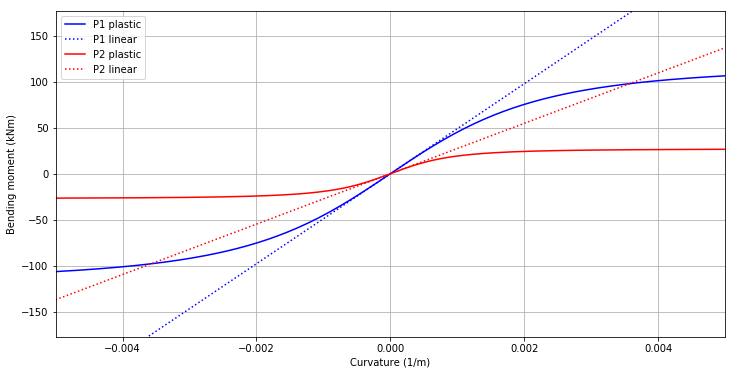

In [11]:
def Mzy(EI, My, gm, wzz):

    M  =  np.zeros(wzz.shape)
    kT = (np.abs(wzz) >  0.0)
    kF = (np.abs(wzz) == 0.0)
    
    M1 = EI*np.abs(wzz)
    M2 = My*np.ones(wzz.shape)
    
    M[kT]  = (1/(1/M1[kT]**gm + 1/M2[kT]**gm))**(1/gm)
    
    return -M*np.sign(wzz)

#---------------------------------------------------------------------------

gamm = 2
wzzi = np.linspace(-0.005, 0.005, 200)       
Mzy1 = Mzy(EI1, My1, gamm, wzzi)   
Mzy2 = Mzy(EI2, My2, gamm, wzzi)   
                 
fig4 = plt.figure(4, figsize=(12,6))

plt.plot(wzzi, -Mzy1, 'b', wzzi, EI1*wzzi, 'b:')
plt.plot(wzzi, -Mzy2, 'r', wzzi, EI2*wzzi, 'r:')
                 
plt.axis([-0.005, 0.005, -1.5*My1, 1.5*My1])
plt.xlabel('Curvature (1/m)')
plt.ylabel('Bending moment (kNm)')
plt.legend(('P1 plastic', 'P1 linear', 'P2 plastic', 'P2 linear'))
plt.grid(True)


## 4. Data analysis through finite differences derivation  <a name="section_4"></a>

In this section a central finite differences scheme is used to estimate successively
the rotation, $\theta(z)$, the curvature, $\psi(z)$, the (elastic) bending moment, $M(z)$, 
the shear force, $Q(z)$ and finally the soil resultant reaction, $p(z)$, from the 
lateral displacement, $u(z)$, recorded from the instrumentation.

Firstly the rotation function, $\theta(z)$, is estimated for pile P1:


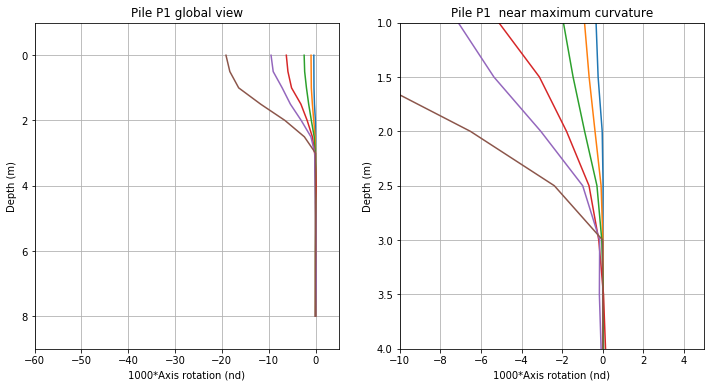

In [12]:
dZ   =  0.5

D1_z  = (D1[2:,:] - D1[:-2,:])/(2*dZ)
D1_zi =  D1_z[0,:] - 0.25*dZ*(D1_z[2,:] - D1_z[0,:])/(2*dZ)  ### SOME BIAS HERE!!!
D1_zf =  np.zeros(D1_zi.shape)
D1_z  =  np.vstack((D1_zi, D1_z, D1_zf))

fig5 = plt.figure(5, figsize=(12,6))

plt.subplot(1,2,1)

for k in N1:
    plt.plot(1000*D1_z[:,k], Z1)

plt.axis([-60, 5, -1, 9])
plt.gca().invert_yaxis()
plt.xlabel('1000*Axis rotation (nd)')
plt.ylabel('Depth (m)')
plt.title('Pile P1 global view')
plt.grid(True)

plt.subplot(1,2,2)

for k in N1:
    plt.plot(1000*D1_z[:,k], Z1)

plt.axis([-10, 5, 1, 4])
plt.gca().invert_yaxis()
plt.xlabel('1000*Axis rotation (nd)')
plt.ylabel('Depth (m)')
plt.title('Pile P1  near maximum curvature')
plt.grid(True)

rotP1 = pd.DataFrame(data=D1_z[:,N1], index=Z1, columns=P1[N1])
rotP1.to_excel(excelP1,'Rotation')


And now for pile P2:

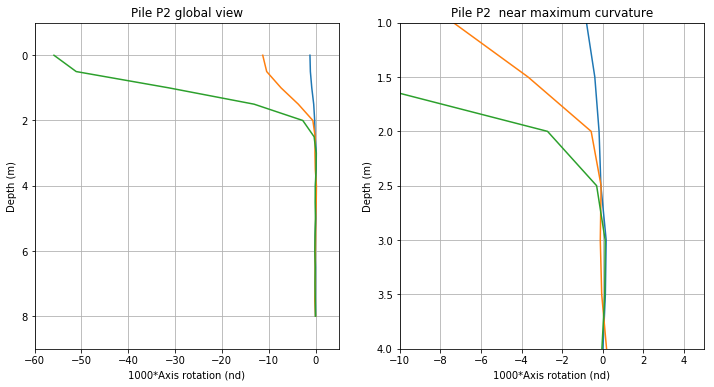

In [13]:
D2_z  = (D2[2:,:] - D2[:-2,:])/(2*dZ)
D2_zi =  D2_z[0,:] - 0.25*dZ*(D2_z[2,:] - D2_z[0,:])/(2*dZ)  ### SOME BIAS HERE!!!
D2_zf =  np.zeros(D2_zi.shape)
D2_z  =  np.vstack((D2_zi, D2_z, D2_zf))

fig6 = plt.figure(6, figsize=(12,6))

plt.subplot(1,2,1)

for k in N2:
    plt.plot(1000*D2_z[:,k], Z2)

plt.axis([-60, 5, -1, 9])
plt.gca().invert_yaxis()
plt.xlabel('1000*Axis rotation (nd)')
plt.ylabel('Depth (m)')
plt.title('Pile P2 global view')
plt.grid(True)

plt.subplot(1,2,2)

for k in N2:
    plt.plot(1000*D2_z[:,k], Z2)

plt.axis([-10, 5, 1, 4])
plt.gca().invert_yaxis()
plt.xlabel('1000*Axis rotation (nd)')
plt.ylabel('Depth (m)')
plt.title('Pile P2  near maximum curvature')
plt.grid(True)

rotP2 = pd.DataFrame(data=D2_z[:,N2], index=Z2, columns=P2[N2])
rotP2.to_excel(excelP2,'Rotation')


## 5. Estimation of bending moments  <a name="section_5"></a>

### 5.1 With a linear moment-curvature relation  <a name="section_52"></a>

Initially we regard the moment-curvature relation as linear. 
For pile P1, the elastic approach gives the following bending moment estimation.


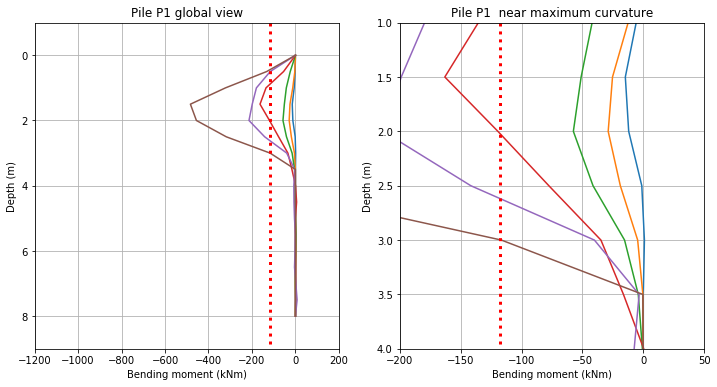

In [14]:
D1_zz  = (D1_z[2:,:] - D1_z[:-2,:])/(2*dZ)
D1_zzi =  np.zeros(len(P1))
D1_zz  =  np.vstack((D1_zzi, D1_zz, D1_zzi))

Mz1    = -EI1*D1_zz

fig7 = plt.figure(7, figsize=(12,6))
plt.subplot(1,2,1)

for k in N1:
    plt.plot(Mz1[:,k], Z1)

plt.plot([-My1, -My1], [-1, 9], 'r:', linewidth=3)
plt.axis([-1200, 200, -1, 9])
plt.gca().invert_yaxis()
plt.xlabel('Bending moment (kNm)')
plt.ylabel('Depth (m)')
plt.title('Pile P1 global view')
plt.grid(True)

plt.subplot(1,2,2)

for k in N1:
    plt.plot(Mz1[:,k], Z1)

plt.plot([-My1, -My1], [1, 4], 'r:', linewidth=3)
plt.axis([-200, 50, 1, 4])
plt.gca().invert_yaxis()
plt.xlabel('Bending moment (kNm)')
plt.ylabel('Depth (m)')
plt.title('Pile P1  near maximum curvature')
plt.grid(True)


And now the same for pile P2:

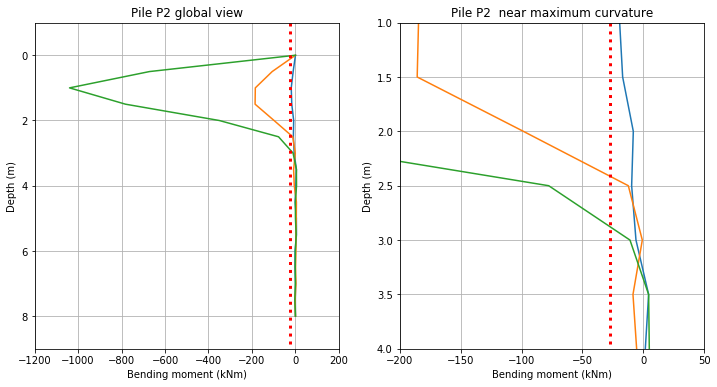

In [15]:
D2_zz  = (D2_z[2:,:] - D2_z[:-2,:])/(2*dZ)
D2_zzi =  np.zeros(len(P2))
D2_zz  =  np.vstack((D2_zzi, D2_zz, D2_zzi))

Mz2    = -EI2*D2_zz

fig8 = plt.figure(8, figsize=(12,6))
plt.subplot(1,2,1)

for k in N2:
    plt.plot(Mz2[:,k], Z2)

plt.plot([-My2, -My2], [-1, 9], 'r:', linewidth=3)
plt.axis([-1200, 200, -1, 9])
plt.gca().invert_yaxis()
plt.xlabel('Bending moment (kNm)')
plt.ylabel('Depth (m)')
plt.title('Pile P2 global view')
plt.grid(True)

plt.subplot(1,2,2)

for k in N2:
    plt.plot(Mz2[:,k], Z2)

plt.plot([-My2, -My2], [1, 4], 'r:', linewidth=3)
plt.axis([-200, 50, 1, 4])
plt.gca().invert_yaxis()
plt.xlabel('Bending moment (kNm)')
plt.ylabel('Depth (m)')
plt.title('Pile P2  near maximum curvature')
plt.grid(True)


The graphic above shows that, for loading beyond 36kN on both piles, the linear 
relation assumption would imply bending moments exceeding by far the limit value $M_{\rm y}$. 
This information corroborates the upper limit verified from the load-displacement curves
previously presented.

Consequently, the test loads of 12, 24 and 36kN for pile P1, and the test load of 20kN
for pile P2, may be regarded as the only cases where piles behave elastically.


### 5.2 With a non-linear moment-curvature relation  <a name="section_52"></a>

The proposed non-linear moment-curvature relation is now used to limit the bending
moment estimation.

Initially for pile P1:


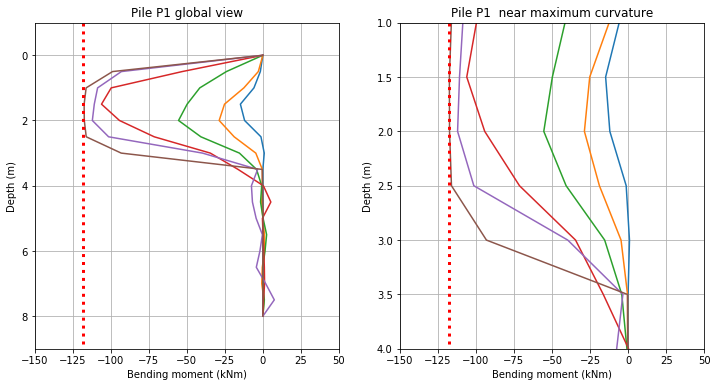

In [16]:
gam1 = 3
Mzy1 = Mzy(EI1, My1, gam1, D1_zz)

fig9 = plt.figure(9, figsize=(12,6))
plt.subplot(1,2,1)

for k in N1:
    plt.plot(Mzy1[:,k], Z1)

plt.plot([-My1, -My1], [-1, 9], 'r:', linewidth=3)
plt.axis([-150, 50, -1, 9])
plt.gca().invert_yaxis()
plt.xlabel('Bending moment (kNm)')
plt.ylabel('Depth (m)')
plt.title('Pile P1 global view')
plt.grid(True)

plt.subplot(1,2,2)

for k in N1:
    plt.plot(Mzy1[:,k], Z1)

plt.plot([-My1, -My1], [1, 4], 'r:', linewidth=3)
plt.axis([-150, 50, 1, 4])
plt.gca().invert_yaxis()
plt.xlabel('Bending moment (kNm)')
plt.ylabel('Depth (m)')
plt.title('Pile P1  near maximum curvature')
plt.grid(True)

momP1 = pd.DataFrame(data=Mzy1[:,N1], index=Z1, columns=P1[N1])
momP1.to_excel(excelP1,'Moments')


And now for pile P2:


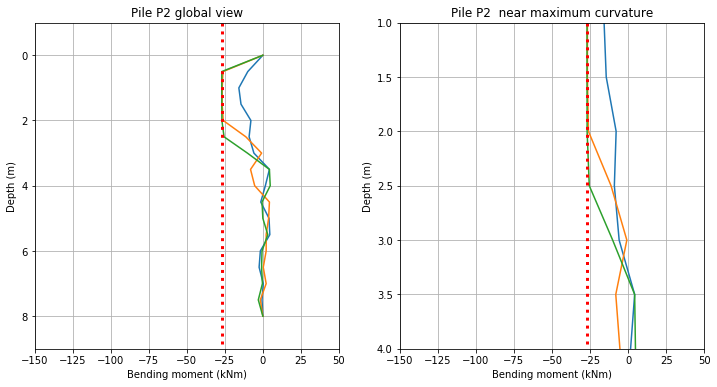

In [17]:
gam2 = 2
Mzy2 = Mzy(EI2, My2, gam2, D2_zz)

fig10 = plt.figure(10, figsize=(12,6))
plt.subplot(1,2,1)

for k in N2:
    plt.plot(Mzy2[:,k], Z2)

plt.plot([-My2, -My2], [-1, 9], 'r:', linewidth=3)
plt.axis([-150, 50, -1, 9])
plt.gca().invert_yaxis()
plt.xlabel('Bending moment (kNm)')
plt.ylabel('Depth (m)')
plt.title('Pile P2 global view')
plt.grid(True)

plt.subplot(1,2,2)

for k in N2:
    plt.plot(Mzy2[:,k], Z2)

plt.plot([-My2, -My2], [1, 4], 'r:', linewidth=3)
plt.axis([-150, 50, 1, 4])
plt.gca().invert_yaxis()
plt.xlabel('Bending moment (kNm)')
plt.ylabel('Depth (m)')
plt.title('Pile P2  near maximum curvature')
plt.grid(True)

momP2 = pd.DataFrame(data=Mzy2[:,N2], index=Z2, columns=P2[N2])
momP2.to_excel(excelP2,'Moments')


## 6. Estimation of shear forces  <a name="section_6"></a>

Shear forces, $Q(z)$, are calculated by applying equilibrium to the bending moment estimaded
under the nonlinear assumption previously described.
Once only equilibrium condition is called, this calculation does not require any further 
assumptions beyond that nonlinear model.

For pile P1 it gives:


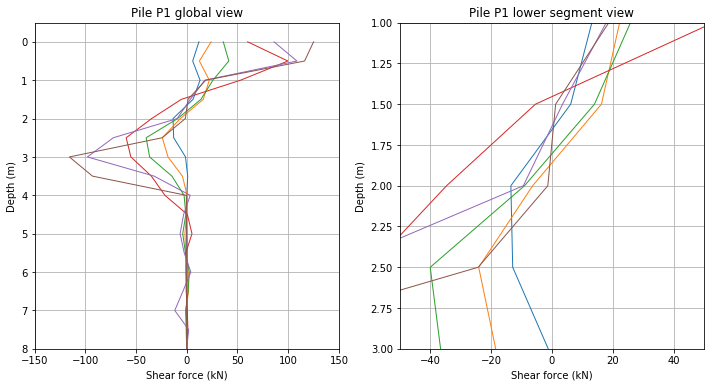

In [18]:
Qz1  = -(Mzy1[2:,:] - Mzy1[:-2,:])/(2*dZ)
Qz1f =   np.zeros(len(P1))
Qz1  =   np.vstack((P1, Qz1, Qz1f))

fig11 = plt.figure(11, figsize=(12,6))

plt.subplot(1,2,1)

for k in N1:
    plt.plot(Qz1[:,k], Z1,  ls='-', lw=1)

plt.axis([-150, 150, -0.5, 8])
plt.gca().invert_yaxis()
plt.xlabel('Shear force (kN)')
plt.ylabel('Depth (m)')
plt.title('Pile P1 global view')
plt.grid(True)

plt.subplot(1,2,2)

for k in N1:
    plt.plot(Qz1[:,k], Z1,  ls='-', lw=1)

plt.axis([-50, 50, 1, 3])
plt.gca().invert_yaxis()
plt.xlabel('Shear force (kN)')
plt.ylabel('Depth (m)')
plt.title('Pile P1 lower segment view')
plt.grid(True)

shearP1 = pd.DataFrame(data=Qz1[:,N1], index=Z1, columns=P1[N1])
shearP1.to_excel(excelP1,'Shear')


While for pile P2:


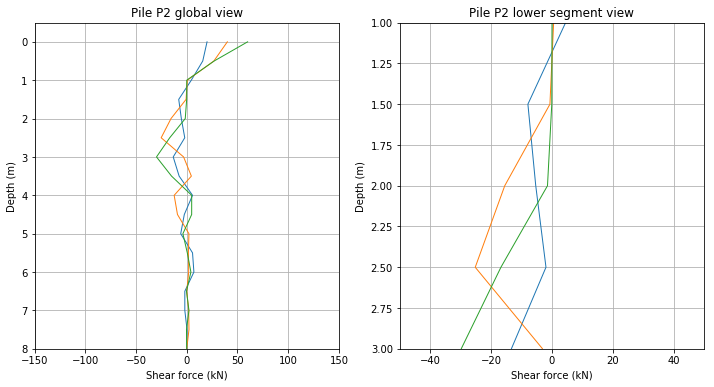

In [19]:
Qz2  = -(Mzy2[2:,:] - Mzy2[:-2,:])/(2*dZ)
Qz2f =   np.zeros(len(P2))
Qz2  =   np.vstack((P2, Qz2, Qz2f))

fig12 = plt.figure(12, figsize=(12,6))

plt.subplot(1,2,1)

for k in N2:
    plt.plot(Qz2[:,k], Z2,  ls='-', lw=1)

plt.axis([-150, 150, -0.5, 8])
plt.gca().invert_yaxis()
plt.xlabel('Shear force (kN)')
plt.ylabel('Depth (m)')
plt.title('Pile P2 global view')
plt.grid(True)

plt.subplot(1,2,2)

for k in N2:
    plt.plot(Qz2[:,k], Z2,  ls='-', lw=1)

plt.axis([-50, 50, 1, 3])
plt.gca().invert_yaxis()
plt.xlabel('Shear force (kN)')
plt.ylabel('Depth (m)')
plt.title('Pile P2 lower segment view')
plt.grid(True)

shearP2 = pd.DataFrame(data=Qz2[:,N2], index=Z2, columns=P2[N2])
shearP2.to_excel(excelP2,'Shear')


## 7. Estimation of soil reactions  <a name="section_7"></a>

Soil reactions, $p(z)$, are also calculated by applying equilibrium to the shear forces
estimated under the nonlinear assumption previously described.

For pile P1 it gives:


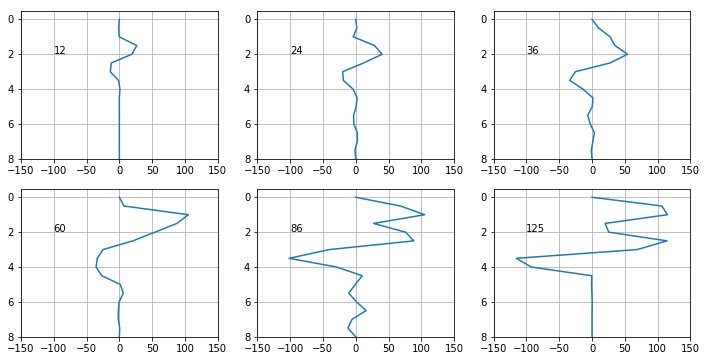

In [20]:
pz1  = -(Qz1[2:,:] - Qz1[:-2,:])/(2*dZ)
pz1i =   np.zeros(len(P1))
pz1  =   np.vstack((pz1i, pz1, pz1i))

fig13 = plt.figure(13, figsize=(12,6))

for i, k in enumerate(N1):
    plt.subplot(2,3,i+1)
    plt.plot(pz1[:,k],   Z1,  ls='-', lw=1.5)

    plt.axis([-150, 150, -0.5, 8])
    plt.gca().invert_yaxis()
    plt.text(-100,2,str(P1[k]))
    plt.grid(True)

reactionP1 = pd.DataFrame(data=pz1[:,N1], index=Z1, columns=P1[N1])
reactionP1.to_excel(excelP1,'Reactions')


The same for pile P2:


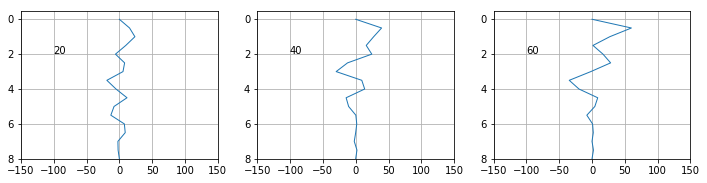

In [21]:
pz2  = -(Qz2[2:,:] - Qz2[:-2,:])/(2*dZ)
pz2i =   np.zeros(len(P2))
pz2  =   np.vstack((pz2i, pz2, pz2i))

fig14 = plt.figure(14, figsize=(12,6))

for i, k in enumerate(N2):
    plt.subplot(2,3,i+1)
    plt.plot(pz2[:,k],   Z2,  ls='-', lw=1)

    plt.axis([-150, 150, -0.5, 8])
    plt.gca().invert_yaxis()
    plt.text(-100,2,str(P2[k]))
    plt.grid(True)

reactionP2 = pd.DataFrame(data=pz2[:,N2], index=Z2, columns=P2[N2])
reactionP2.to_excel(excelP2,'Reactions')


## 8. Model fitting  <a name="section_8"></a>

Now let us assume a continuous model for the soil reaction: 

$$ p(z) =   p_0 \left(\frac{z}{\lambda}\right)^\beta
           \exp\left[-\zeta \left(\frac{z}{\lambda} \right)^\alpha \right]
           \sin\left[ \pi   \left(\frac{z}{\lambda} \right)^\alpha \right] $$

which requires 6 parameters to be estimated. The model consists in a damped sine function,
with a wavelength that decreases with $z$. It is assumed that this type of function may
fit satisfactorily all the observed estimations of $p(z)$. 

The fitting procedure is programmed to minimize the error on the two-fold integral
of $p(z)$, as compared to the nonlinear estimation of bending moments. Firstly we define the
model functions:


In [22]:
def p_model(z, pz0, zta, lbd, alf, bet):
    
    zw  = (zi/lbd)**alf
    z0  = (zi/lbd)**bet
    pi  =  pz0*z0*np.exp(-zta*zw)*np.sin(np.pi*zw)

    fp =  interp1d(zi, pi, kind='cubic')
    return fp(z)

#------------------------------------------------------

def M_model(z, pz0, zta, lbd, alf, bet):

    pi  =  p_model(zi[::-1], pz0, zta, lbd, alf, bet)
    
    Qi  =  np.cumsum(pi)*dZi
    Qi  =  Qi - (Qi[-1] - Q0)*zi/L
    
    Mi  =  np.cumsum(Qi)*dZi
    Mi  =  Mi - (Mi[-1] - 0.)*zi/L

    fM =  interp1d(zi, Mi[::-1], kind='cubic')
    return fM(z)

#------------------------------------------------------

def D_model(z, pz0, zta, lbd, alf, bet):

    Myi =   M_model(zi[::-1], pz0, zta, lbd, alf, bet)
    kT  =   Myi != 0.0
    Ki  =   np.zeros(Myi.shape)
    
    dM     =  (1/(np.abs(Myi[kT])))**gm - (1/My)**gm
    dM[dM <= 0.0] = 0.01*dM.max()
    Ki[kT] =   dM 
    Ki[kT] =  (1/Ki[kT])**(1/gm) 
    Ki     = -(1/EI)*Ki*np.sign(Myi)

    Ri  =  np.cumsum(Ki)*dZi
    Di  =  np.cumsum(Ri)*dZi
    Di  =  Di - (Di[-1] - D0)*zi/L

    fD =  interp1d(zi, Di[::-1], kind='cubic')
    return fD(z)


The proposed model does not work for moments too close to plastic limit. 
Only the first tests of each pile will be used in the analysis.
The lists of tests to be considered are re-defined below:


In [23]:
N1  =  np.array([ 0, 2, 4, 8], dtype='int')
N2  =  np.array([ 0, 2      ], dtype='int')


Now the fitting is carried out for pile P1:


In [24]:
L    =  L1
EI   =  EI1
My   =  My1
gm   =  gam1

dZi  =  L/1000
zi   =  np.linspace(0, L, 1000)
pM   =  np.zeros((len(zi),len(P1)))
MM   =  np.zeros((len(zi),len(P1)))
DM   =  np.zeros((len(zi),len(P1)))
P    =  np.zeros((len(Z1), 5)) 

#        pz0     zta     lbd    alpha    beta
Pmin = (   0.,   0.1,   2.00,     0.1,    0.1)   # lower bounds
P0   = (  50.,   2.5,   2.50,     1.5,    2.0)   # initial guesses
Pmax = ( 500,    5.0,   3.00,     4.0,    4.0)   # upper bounds

for k in N1:
    Q0 = P1[k]
    D0 = D1[0,k]
    
    P[k,:], cv = curve_fit(M_model, Z1, Mzy1[:,k], p0=P0, bounds=(Pmin, Pmax))

    pM[:,k]    = p_model(zi, *P[k,:])
    MM[:,k]    = M_model(zi, *P[k,:])
    DM[:,k]    = D_model(zi, *P[k,:])

np.set_printoptions(precision=2)
print(P[N1,:])


[[500.     2.42   2.28   1.72   4.  ]
 [500.     3.04   2.75   1.01   2.3 ]
 [500.     1.95   2.71   1.59   2.2 ]
 [500.     1.61   2.73   1.66   1.35]]


take a look at the results. Firstly, the fitted soil reaction:


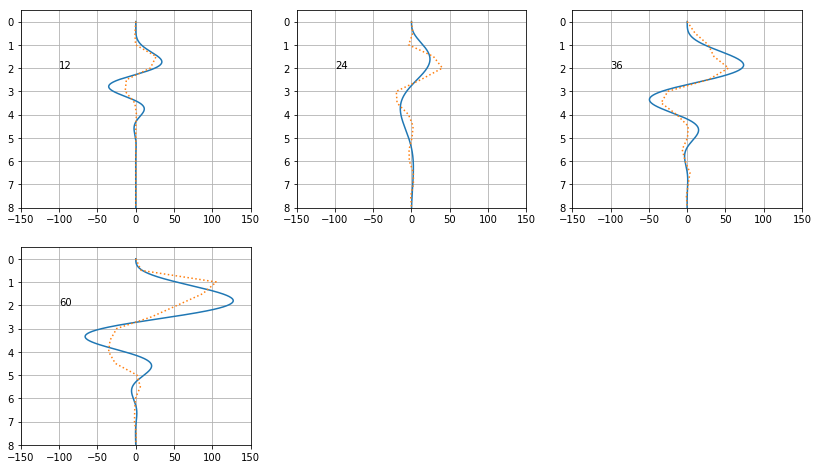

In [25]:
fig16 = plt.figure(16, figsize=(14,8))

for i, k in enumerate(N1):
    plt.subplot(2,3,i+1)
    plt.plot( pM[:,k], zi, ls='-')
    plt.plot(pz1[:,k], Z1, ls=':')

    plt.axis([-150, 150, -0.5, 8])
    plt.gca().invert_yaxis()
    plt.text(-100,2,str(P1[k]))
    plt.grid(True)

fitreactionP1 = pd.DataFrame(data=pM[:,N1], index=zi, columns=P1[N1])
fitreactionP1.to_excel(excelP1,'Fit_Reactions')


Then, the non-linear bending moment:


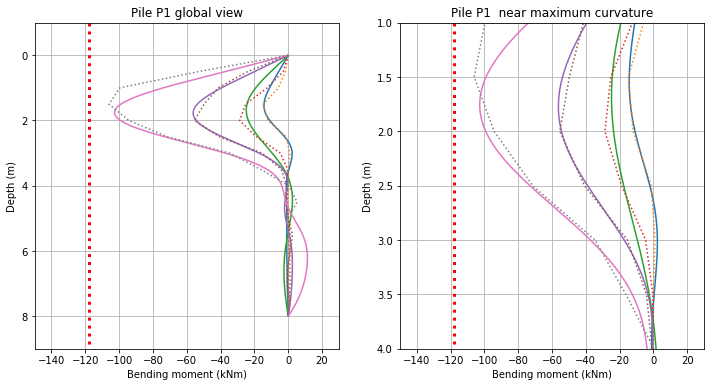

In [26]:
fig17 = plt.figure(17, figsize=(12,6))
plt.subplot(1,2,1)

for k in N1:
    plt.plot(MM[:,k],   zi, ls='-')
    plt.plot(Mzy1[:,k], Z1, ls=':')

plt.plot([-My1, -My1], [-1, 9], 'r:', linewidth=3)
plt.axis([-150, 30, -1, 9])
plt.gca().invert_yaxis()
plt.xlabel('Bending moment (kNm)')
plt.ylabel('Depth (m)')
plt.title('Pile P1 global view')
plt.grid(True)

plt.subplot(1,2,2)

for k in N1:
    plt.plot(MM[:,k],   zi, ls='-')
    plt.plot(Mzy1[:,k], Z1, ls=':')

plt.plot([-My1, -My1], [1, 4], 'r:', linewidth=3)
plt.axis([-150, 30, 1, 4])
plt.gca().invert_yaxis()
plt.xlabel('Bending moment (kNm)')
plt.ylabel('Depth (m)')
plt.title('Pile P1  near maximum curvature')
plt.grid(True)

fitmomentP1 = pd.DataFrame(data=MM[:,N1], index=zi, columns=P1[N1])
fitmomentP1.to_excel(excelP1,'Fit_Moments')


And the displacement, which is the original information:


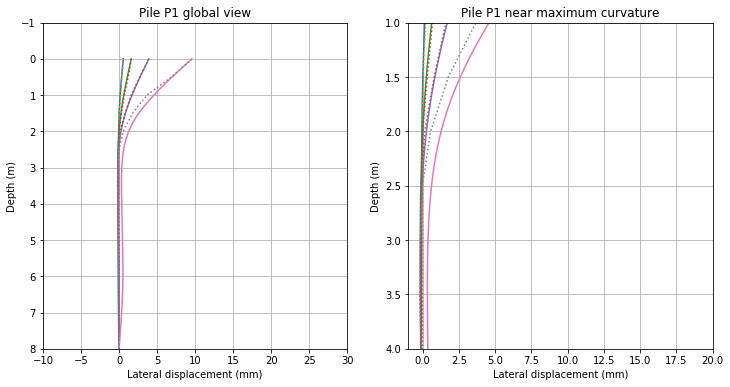

In [27]:
fig18 = plt.figure(16, figsize=(12,6))

plt.subplot(1,2,1)

for k in N1:
    plt.plot(1000*DM[:,k], zi, ls='-')
    plt.plot(1000*D1[:,k], Z1, ls=':')

plt.axis([-10, 30, -1, L1])
plt.gca().invert_yaxis()
plt.xlabel('Lateral displacement (mm)')
plt.ylabel('Depth (m)')
plt.title('Pile P1 global view')
plt.grid(True)

plt.subplot(1,2,2)

for k in N1:
    plt.plot(1000*DM[:,k], zi, ls='-')
    plt.plot(1000*D1[:,k], Z1, ls=':')

plt.axis([-1, 20, 1, 4])
plt.gca().invert_yaxis()
plt.xlabel('Lateral displacement (mm)')
plt.ylabel('Depth (m)')
plt.title('Pile P1 near maximum curvature')
plt.grid(True)

fitdisplP1 = pd.DataFrame(data=DM[:,N1], index=zi, columns=P1[N1])
fitdisplP1.to_excel(excelP1,'Fit_Displacements')


Now, the fitting for pile P2:


In [28]:
L    =  L2
EI   =  EI2
My   =  My2
gm   =  gam2

dZi  =  L/1000
zi   =  np.linspace(0, L, 1000)
pM   =  np.zeros((len(zi),len(P2)))
MM   =  np.zeros((len(zi),len(P2)))
DM   =  np.zeros((len(zi),len(P2)))
P    =  np.zeros((len(Z2), 5)) 

##          pz0    zta     lbd    alpha    beta
#Pmin = (    0.,   2.0,   2.00,     0.5,    0.5)   # lower bounds
#P0   = (  500.,   2.5,   2.50,     1.5,    2.0)   # initial guesses
#Pmax = ( 2000.,   3.5,   3.00,     2.0,    3.5)   # upper bounds

for k in N2:
    Q0 = P2[k]
    D0 = D2[0,k]
    
    P[k,:], cv = curve_fit(M_model, Z2, Mzy2[:,k], p0=P0, bounds=(Pmin, Pmax))

    pM[:,k]    = p_model(zi, *P[k,:])
    MM[:,k]    = M_model(zi, *P[k,:])
    DM[:,k]    = D_model(zi, *P[k,:])

np.set_printoptions(precision=2)
print(P[N2,:])


[[500.     3.61   2.27   0.68   1.4 ]
 [500.     3.25   2.08   0.89   0.83]]


The result for the soil reaction is plotted below:


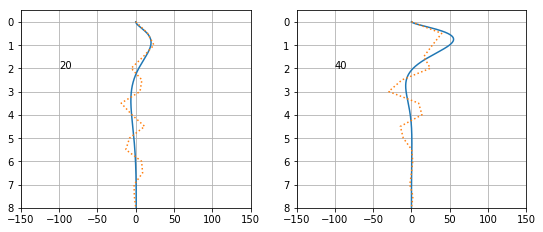

In [29]:
fig19 = plt.figure(16, figsize=(14,8))

for i, k in enumerate(N2):
    plt.subplot(2,3,i+1)
    plt.plot( pM[:,k], zi, ls='-')
    plt.plot(pz2[:,k], Z1, ls=':')

    plt.axis([-150, 150, -0.5, 8])
    plt.gca().invert_yaxis()
    plt.text(-100,2,str(P2[k]))
    plt.grid(True)

fitreactionP2 = pd.DataFrame(data=pM[:,N2], index=zi, columns=P2[N2])
fitreactionP2.to_excel(excelP2,'Fit_Reactions')


For the nonlinear bending moment in pile P2:


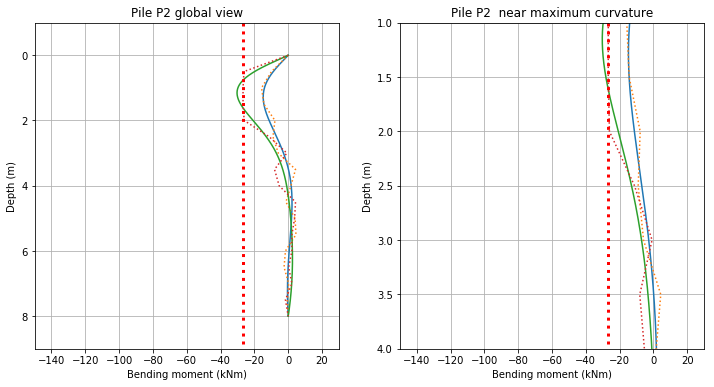

In [30]:
fig20 = plt.figure(20, figsize=(12,6))
plt.subplot(1,2,1)

for k in N2:
    plt.plot(MM[:,k],   zi, ls='-')
    plt.plot(Mzy2[:,k], Z2, ls=':')

plt.plot([-My2, -My2], [-1, 9], 'r:', linewidth=3)
plt.axis([-150, 30, -1, 9])
plt.gca().invert_yaxis()
plt.xlabel('Bending moment (kNm)')
plt.ylabel('Depth (m)')
plt.title('Pile P2 global view')
plt.grid(True)

plt.subplot(1,2,2)

for k in N2:
    plt.plot(MM[:,k],   zi, ls='-')
    plt.plot(Mzy2[:,k], Z2, ls=':')

plt.plot([-My2, -My2], [1, 4], 'r:', linewidth=3)
plt.axis([-150, 30, 1, 4])
plt.gca().invert_yaxis()
plt.xlabel('Bending moment (kNm)')
plt.ylabel('Depth (m)')
plt.title('Pile P2  near maximum curvature')
plt.grid(True)

fitmomentP2 = pd.DataFrame(data=MM[:,N2], index=zi, columns=P2[N2])
fitmomentP2.to_excel(excelP2,'Fit_Moments')


And finally for the displacement in pile P2:
    

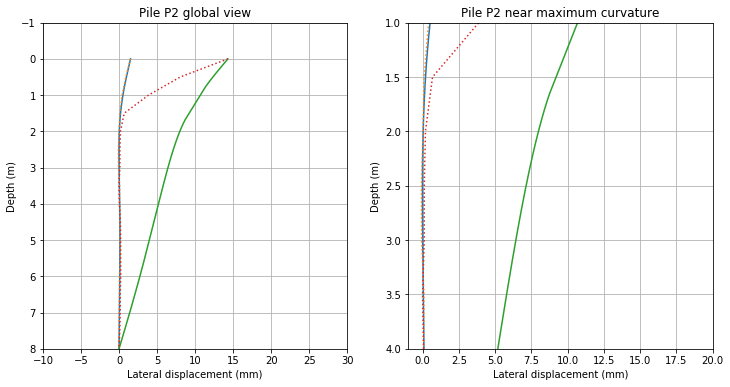

In [31]:
fig21 = plt.figure(21, figsize=(12,6))

plt.subplot(1,2,1)

for k in N2:
    plt.plot(1000*DM[:,k], zi, ls='-')
    plt.plot(1000*D2[:,k], Z2, ls=':')

plt.axis([-10, 30, -1, L2])
plt.gca().invert_yaxis()
plt.xlabel('Lateral displacement (mm)')
plt.ylabel('Depth (m)')
plt.title('Pile P2 global view')
plt.grid(True)

plt.subplot(1,2,2)

for k in N2:
    plt.plot(1000*DM[:,k], zi, ls='-')
    plt.plot(1000*D2[:,k], Z2, ls=':')

plt.axis([-1, 20, 1, 4])
plt.gca().invert_yaxis()
plt.xlabel('Lateral displacement (mm)')
plt.ylabel('Depth (m)')
plt.title('Pile P2 near maximum curvature')
plt.grid(True)

fitdisplP2 = pd.DataFrame(data=DM[:,N2], index=zi, columns=P2[N2])
fitdisplP2.to_excel(excelP2,'Fit_Displacements')


## 9. Conclusions <a name="section_9"></a>

The fitting has intentionally included a test beyond method capability, to show how the model starts to fail in representing to large plastic curvatures. Below this condition, the fitting quality is very good.


In [32]:
excelP1.save()
excelP2.save()
